# **Produisez une étude de marché avec pyhton**

## Description

Ce projet s'inscrit dans le cadre d'une mission de consultant Data Analyst au sein de LA poule qui chante. L'objectif principal est de développer une étude de marché sur un groupe de pays cible pour exporter leurs poulets. 
Les données fournis sont celles de la FAO (Food and Agriculture Organisation), j'ai choisi de rajouter quelques données supplémentaires afin d'affiner l'analyse.
Ce projet évalue les compétences d'étude d'un jeu de données afin d'en synthétiser des variables, ainsi que la mise en place de solution de clustering.

## Table des matières

- [Import](#I.Import)
- [Analyse](#II.Jointures)
- [Traitement des données manquantes en utilisant une régression linéaire multiple.](#III.Manipulation)

# I. Import

## Import

In [80]:
# installations et imports des autres packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import fonctions as fc

## Sheet data

In [81]:
# file path
data_file_path = "DisponibiliteAlimentaire_2017.csv"
# data_file_path = "/content/drive/MyDrive/OC/P9/DATA/DisponibiliteAlimentaire_2017.csv"
df_data = pd.read_csv(data_file_path)

In [82]:
# Utilisation de la fonction
fc.etude_fichier(df_data)

Nombre de colonnes : (176600, 14)

Le type est : 
 Code Domaine               object
Domaine                    object
Code zone                   int64
Zone                       object
Code Élément                int64
Élément                    object
Code Produit                int64
Produit                    object
Code année                  int64
Année                       int64
Unité                      object
Valeur                    float64
Symbole                    object
Description du Symbole     object
dtype: object

Nombre de valeurs uniques :
Code Domaine                 1
Domaine                      1
Code zone                  174
Zone                       174
Code Élément                17
Élément                     17
Code Produit                98
Produit                     98
Code année                   1
Année                        1
Unité                        4
Valeur                    7250
Symbole                      2
Description du Symbole     

**Unités**

Unité = 'Milliers de tonnes', 'kg', Kcal/personne/jour', 'g/personne/jour'

Description du Symbole = 'Données standardisées', 'Donnée calculée'

Les colonnes 'Code' ne nous intéressent pas pour l'analyse nous allons donc les supprimer

In [83]:
# Sélection des colonnes
colonnes_a_supprimer = ['Code Domaine', 'Code zone','Description du Symbole', 'Code Élément', 'Code Produit',  'Code année', 'Symbole', "Domaine"]

# Supprimer les colonnes du dataframe final
df_data = df_data.drop(columns=colonnes_a_supprimer)

# Afficher les premières lignes du nouveau dataframe
df_data.head()

,Zone,Élément,Produit,Année,Unité,Valeur
0,Afghanistan,Production,Blé et produits,2017,Milliers de tonnes,4281.0
1,Afghanistan,Importations - Quantité,Blé et produits,2017,Milliers de tonnes,2302.0
2,Afghanistan,Variation de stock,Blé et produits,2017,Milliers de tonnes,-119.0
3,Afghanistan,Exportations - Quantité,Blé et produits,2017,Milliers de tonnes,0.0
4,Afghanistan,Disponibilité intérieure,Blé et produits,2017,Milliers de tonnes,6701.0


Notre étude porte sur le commerce de poukte, nous allons donc garder le périmètre correspondant à la viande de vollaile. On ne va aussi garder que les éléments en rapport avec la nourriture.

In [84]:
df_data = df_data[df_data['Produit'] == 'Viande de Volailles'] # On ne garde que les produits de type viande de volailles
df_data = df_data[df_data['Élément'].isin(['Production', 'Importations - Quantité', 'Exportations - Quantité', 'Disponibilité intérieure', 'Disponibilité de protéines en quantité (g/personne/jour)'])] # On ne garde que les éléments de type nourriture
df_data.head(10)

,Zone,Élément,Produit,Année,Unité,Valeur
651,Afghanistan,Production,Viande de Volailles,2017,Milliers de tonnes,28.00
652,Afghanistan,Importations - Quantité,Viande de Volailles,2017,Milliers de tonnes,29.00
654,Afghanistan,Disponibilité intérieure,Viande de Volailles,2017,Milliers de tonnes,57.00
660,Afghanistan,Disponibilité de protéines en quantité (g/pers...,Viande de Volailles,2017,g/personne/jour,0.54
1704,Afrique du Sud,Production,Viande de Volailles,2017,Milliers de tonnes,1667.00
1705,Afrique du Sud,Importations - Quantité,Viande de Volailles,2017,Milliers de tonnes,514.00
1707,Afrique du Sud,Exportations - Quantité,Viande de Volailles,2017,Milliers de tonnes,63.00
1708,Afrique du Sud,Disponibilité intérieure,Viande de Volailles,2017,Milliers de tonnes,2118.00
1715,Afrique du Sud,Disponibilité de protéines en quantité (g/pers...,Viande de Volailles,2017,g/personne/jour,14.11
2713,Albanie,Production,Viande de Volailles,2017,Milliers de tonnes,13.00


Nous allons pivoter notre datframe afin de regrouper les données par pays sur une seule ligne

In [85]:
# Utilisez la fonction pivot_table pour effectuer la transformation
df_data = df_data.pivot_table(index=['Zone'],
                                columns='Élément',
                                values='Valeur',
                                aggfunc='sum').reset_index()

# Affiche le DataFrame transformé
df_data.head()

Élément,Zone,Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Production
0,Afghanistan,0.54,57.0,NaN,29.0,28.0
1,Afrique du Sud,14.11,2118.0,63.0,514.0,1667.0
2,Albanie,6.26,47.0,0.0,38.0,13.0
3,Algérie,1.97,277.0,0.0,2.0,275.0
4,Allemagne,7.96,1739.0,646.0,842.0,1514.0


## sheet population

In [86]:
# file path
population_file_path = "Population_2000_2018.csv"
# population_file_path = "/content/drive/MyDrive/OC/P9/DATA/Population_2000_2018.csv"
df_population = pd.read_csv(population_file_path)

### Etude

In [87]:
df_population.head()

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2000,2000,1000 personnes,20779.953,X,Sources internationales sûres,NaN
1,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2001,2001,1000 personnes,21606.988,X,Sources internationales sûres,NaN
2,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2002,2002,1000 personnes,22600.770,X,Sources internationales sûres,NaN
3,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2003,2003,1000 personnes,23680.871,X,Sources internationales sûres,NaN
4,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2004,2004,1000 personnes,24726.684,X,Sources internationales sûres,NaN


In [88]:
fc.etude_fichier(df_population)

Nombre de colonnes : (4411, 15)

Le type est : 
 Code Domaine               object
Domaine                    object
Code zone                   int64
Zone                       object
Code Élément                int64
Élément                    object
Code Produit                int64
Produit                    object
Code année                  int64
Année                       int64
Unité                      object
Valeur                    float64
Symbole                    object
Description du Symbole     object
Note                       object
dtype: object

Nombre de valeurs uniques :
Code Domaine                 1
Domaine                      1
Code zone                  238
Zone                       238
Code Élément                 1
Élément                      1
Code Produit                 1
Produit                      1
Code année                  19
Année                       19
Unité                        1
Valeur                    4398
Symbole                   

Nous allons sélectionner les colonnes qui nous intéreesent à savoir la popualtion par pays, l'année av nous servir pour faire la jointure.

In [89]:
# Liste des colonnes à supprimer
colonnes_a_supprimer = ['Code Domaine', 'Code zone', 'Code Élément', 'Élément','Code Produit', 'Code année', 'Unité', 'Symbole', 'Description du Symbole', 'Note', "Domaine", "Produit"]

# Supprimer les colonnes du dataframe final
df_population = df_population.drop(columns=colonnes_a_supprimer)

# Renommer la colonne
df_population = df_population.rename(columns={"Valeur": "Population"})

# Afficher les premières lignes du nouveau dataframe
df_population.head()

,Zone,Année,Population
0,Afghanistan,2000,20779.953
1,Afghanistan,2001,21606.988
2,Afghanistan,2002,22600.770
3,Afghanistan,2003,23680.871
4,Afghanistan,2004,24726.684


La population est exorimé dans l'unité 1000 personnes, nous allons donc multiplier notre valeur par 1000. L'année qui correspond aux reste de nos données est 2017.

In [90]:
# Convertion en int
df_population['Population'] = pd.to_numeric(df_population['Population'], errors='coerce')

# Convertion en integer
df_population['Population'] = df_population['Population'].astype(int)

# Afficher les premières lignes du nouveau dataframe
df_population = df_population[df_population['Année'] == 2017]

df_population.head(10)

,Zone,Année,Population
17,Afghanistan,2017,36296
36,Afrique du Sud,2017,57009
55,Albanie,2017,2884
74,Algérie,2017,41389
93,Allemagne,2017,82658
112,Andorre,2017,77
131,Angola,2017,29816
150,Anguilla,2017,14
169,Antigua-et-Barbuda,2017,95
188,Antilles néerlandaises (ex),2017,275


## sheet PIB

In [91]:
# # file path
population_file_path = "PIB_par_hab_2017.csv"
# population_file_path = "/content/drive/MyDrive/OC/P9/DATA/PIB_par_hab_2017.csv"
df_pib = pd.read_csv(population_file_path)
df_pib.head()

,Code Domaine,Domaine,Code zone (M49),Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,MK,Indicateurs macro,4,Afghanistan,6119,Valeur US $ par habitant,22008,Produit Intérieur Brut,2017,2017,US$,530.149831,X,Ciffre de sources internationales,NaN
1,MK,Indicateurs macro,710,Afrique du Sud,6119,Valeur US $ par habitant,22008,Produit Intérieur Brut,2017,2017,US$,6723.928582,X,Ciffre de sources internationales,NaN
2,MK,Indicateurs macro,8,Albanie,6119,Valeur US $ par habitant,22008,Produit Intérieur Brut,2017,2017,US$,4521.752217,X,Ciffre de sources internationales,NaN
3,MK,Indicateurs macro,12,Algérie,6119,Valeur US $ par habitant,22008,Produit Intérieur Brut,2017,2017,US$,4134.936055,X,Ciffre de sources internationales,NaN
4,MK,Indicateurs macro,276,Allemagne,6119,Valeur US $ par habitant,22008,Produit Intérieur Brut,2017,2017,US$,44670.222282,X,Ciffre de sources internationales,NaN


Nous ne gardons que la donnée qui nous intéresse, le PIB par habitant.

In [92]:
# Liste des colonnes à supprimer
colonnes_a_supprimer = ['Année','Code Domaine', 'Code zone (M49)', 'Code Élément', 'Élément','Code Produit', 'Code année', 'Unité', 'Symbole', 'Description du Symbole', 'Note', "Domaine", "Produit"]

# Supprimer les colonnes du dataframe final
df_pib = df_pib.drop(columns=colonnes_a_supprimer)

# Renommer la colonne
df_pib = df_pib.rename(columns={"Valeur": "PIB US $ par habitant"})

# Afficher les premières lignes du nouveau dataframe
df_pib.head()

,Zone,PIB US $ par habitant
0,Afghanistan,530.149831
1,Afrique du Sud,6723.928582
2,Albanie,4521.752217
3,Algérie,4134.936055
4,Allemagne,44670.222282


## Sheet Sous-alimentation

In [93]:
# file path
population_file_path = "nb_personnes_sous_alimenté_2017.csv"
# population_file_path = "/content/drive/MyDrive/OC/P9/DATA/nb_personnes_sous_alimenté_2017.csv"
df_sous_nutrition = pd.read_csv(population_file_path)
df_sous_nutrition.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Code Domaine            204 non-null    object 
 1   Domaine                 204 non-null    object 
 2   Code zone (M49)         204 non-null    int64  
 3   Zone                    204 non-null    object 
 4   Code Élément            204 non-null    int64  
 5   Élément                 204 non-null    object 
 6   Code Produit            204 non-null    int64  
 7   Produit                 204 non-null    object 
 8   Code année              204 non-null    int64  
 9   Année                   204 non-null    object 
 10  Unité                   204 non-null    object 
 11  Valeur                  117 non-null    object 
 12  Symbole                 204 non-null    object 
 13  Description du Symbole  204 non-null    object 
 14  Note                    0 non-null      fl

In [94]:
df_sous_nutrition.head()

,Code Domaine,Domaine,Code zone (M49),Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,FS,Données de la sécurité alimentaire,528,Pays-Bas (Royaume des),6132,Valeur,210011,Nombre de personnes sous-alimentées (millions)...,20162018,2016-2018,millions No,NaN,Q,Valeur manquante; supprimée,NaN
1,FS,Données de la sécurité alimentaire,4,Afghanistan,6132,Valeur,210011,Nombre de personnes sous-alimentées (millions)...,20162018,2016-2018,millions No,8.1,E,Valeur estimée,NaN
2,FS,Données de la sécurité alimentaire,710,Afrique du Sud,6132,Valeur,210011,Nombre de personnes sous-alimentées (millions)...,20162018,2016-2018,millions No,3.2,E,Valeur estimée,NaN
3,FS,Données de la sécurité alimentaire,8,Albanie,6132,Valeur,210011,Nombre de personnes sous-alimentées (millions)...,20162018,2016-2018,millions No,0.1,E,Valeur estimée,NaN
4,FS,Données de la sécurité alimentaire,12,Algérie,6132,Valeur,210011,Nombre de personnes sous-alimentées (millions)...,20162018,2016-2018,millions No,1.1,E,Valeur estimée,NaN


Transformation des données non numériques afin d'éviter les erreurs

In [95]:
df_sous_nutrition['Valeur'] = df_sous_nutrition['Valeur'].replace('<0.1', '0.1')
df_sous_nutrition['Valeur'] = df_sous_nutrition['Valeur'].astype(float)

Nous ne gardons que les données qui nous intéressent, le nombre de personnes sous alimentés exprimé en millions.

In [96]:
# Liste des colonnes à supprimer
colonnes_a_supprimer = ['Année','Code Domaine', 'Code zone (M49)', 'Code Élément', 'Élément','Code Produit', 'Code année', 'Unité', 'Symbole', 'Description du Symbole', 'Note', "Domaine", "Produit"]

# Supprimer les colonnes du dataframe final
df_sous_nutrition = df_sous_nutrition.drop(columns=colonnes_a_supprimer)

# Renommer la colonne
df_sous_nutrition = df_sous_nutrition.rename(columns={"Valeur": "Nombre de personnes sous-alimentées"})

# Afficher les premières lignes
df_sous_nutrition.head()

,Zone,Nombre de personnes sous-alimentées
0,Pays-Bas (Royaume des),NaN
1,Afghanistan,8.1
2,Afrique du Sud,3.2
3,Albanie,0.1
4,Algérie,1.1


Les fichiers on été préapré en vue de la jointure. Nosu allons faire le rapprochement par pays sur l'année 2017. Le fichier de "base" sera df_data.

# II.Jointures

In [97]:
# Jointures des deux df
data = pd.merge(df_data, df_population, on=['Zone'])
data.head()

,Zone,Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Production,Année,Population
0,Afghanistan,0.54,57.0,NaN,29.0,28.0,2017,36296
1,Afrique du Sud,14.11,2118.0,63.0,514.0,1667.0,2017,57009
2,Albanie,6.26,47.0,0.0,38.0,13.0,2017,2884
3,Algérie,1.97,277.0,0.0,2.0,275.0,2017,41389
4,Allemagne,7.96,1739.0,646.0,842.0,1514.0,2017,82658


In [98]:
data = pd.merge(data, df_pib, on=['Zone'])

In [99]:
data.head()

,Zone,Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Production,Année,Population,PIB US $ par habitant
0,Afghanistan,0.54,57.0,NaN,29.0,28.0,2017,36296,530.149831
1,Afrique du Sud,14.11,2118.0,63.0,514.0,1667.0,2017,57009,6723.928582
2,Albanie,6.26,47.0,0.0,38.0,13.0,2017,2884,4521.752217
3,Algérie,1.97,277.0,0.0,2.0,275.0,2017,41389,4134.936055
4,Allemagne,7.96,1739.0,646.0,842.0,1514.0,2017,82658,44670.222282


In [100]:
data = pd.merge(data, df_sous_nutrition, on=['Zone'])
data.head()

,Zone,Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Production,Année,Population,PIB US $ par habitant,Nombre de personnes sous-alimentées
0,Afghanistan,0.54,57.0,NaN,29.0,28.0,2017,36296,530.149831,8.1
1,Afrique du Sud,14.11,2118.0,63.0,514.0,1667.0,2017,57009,6723.928582,3.2
2,Albanie,6.26,47.0,0.0,38.0,13.0,2017,2884,4521.752217,0.1
3,Algérie,1.97,277.0,0.0,2.0,275.0,2017,41389,4134.936055,1.1
4,Allemagne,7.96,1739.0,646.0,842.0,1514.0,2017,82658,44670.222282,NaN


Nous avons donc maintenant toutes nos colonnes nécessaires pour le reste de l'étude.

Passons maintenant aux manipulations.

# III.Manipulation

## début de l'analsye

Nous allons retirer l'Inde et la Chine de l'étude. Ce choix a été effectué après l'exploration car toutes nos données sont pondéré pas la population. Ces deux pays ayant une popualtion largement supérieur aux autres pertubait l'abalyse et le clustering.

In [101]:
data = data.drop(data[data['Zone'].isin(['Inde', 'Chine'])].index)

Nous allons mettre toutes nos colonnes au même ordre de grandeur. 

In [102]:
#transformation en Kg de toutes les données
data['Disponibilité intérieure'] = data['Disponibilité de protéines en quantité (g/personne/jour)']* 1000000*365
data['Importations - Quantité'] = data['Importations - Quantité'] * 1000000
data['Production'] = data['Production']  * 1000000
data['Exportations - Quantité'] = data['Exportations - Quantité']  * 1000000

# Multiplier par 1000 pour respecter l'unité
data['Population'] = data['Population']*1000

# Mettre à la bonne échelle poyr respecter l'unité de la donnée
df_sous_nutrition['Nombre de personnes sous-alimentées'] = df_sous_nutrition['Nombre de personnes sous-alimentées']*1000000
data.head()

,Zone,Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Production,Année,Population,PIB US $ par habitant,Nombre de personnes sous-alimentées
0,Afghanistan,0.54,1.971000e+08,NaN,29000000.0,2.800000e+07,2017,36296000,530.149831,8.1
1,Afrique du Sud,14.11,5.150150e+09,63000000.0,514000000.0,1.667000e+09,2017,57009000,6723.928582,3.2
2,Albanie,6.26,2.284900e+09,0.0,38000000.0,1.300000e+07,2017,2884000,4521.752217,0.1
3,Algérie,1.97,7.190500e+08,0.0,2000000.0,2.750000e+08,2017,41389000,4134.936055,1.1
4,Allemagne,7.96,2.905400e+09,646000000.0,842000000.0,1.514000e+09,2017,82658000,44670.222282,NaN


Afin d'avoir une image des pays non baisé par leur population nous allons pondérer nos colonnes qui ne le sont pas déjà.

In [103]:
# pondération par la population de nos colonnes qui ne le sont pas déjà
data['Disponibilité intérieure'] = data['Disponibilité intérieure'] / data['Population']
data['Importations - Quantité'] = data['Importations - Quantité'] / data['Population']
data['Exportations - Quantité'] = data['Exportations - Quantité'] / data['Population']
data['Production'] = data['Production'] / data['Population']
data['Disponibilité de protéines en quantité (g/personne/jour)'] = data['Disponibilité de protéines en quantité (g/personne/jour)'] * 365

Nous allons donc renommer nos colonnes pour représenter les nouvelles valeurs, et retirer la colonne année qui n'a plus d'utilité.

In [104]:
# renommage des colonnes pour avoir des noms plus explicites
data.rename(columns={'Disponibilité de protéines en quantité (g/personne/jour)': 'Disponibilité de protéines en quantité (kg/personne)'}, inplace=True)
data.rename(columns={'Disponibilité intérieure': 'Disponibilité intérieure/ Population'}, inplace=True)
data.rename(columns={'Exportations - Quantité': 'Exportations / Population'}, inplace=True)
data.rename(columns={'Importations - Quantité': 'Importations / Population'}, inplace=True)
data.rename(columns={'Production': 'Production / Population'}, inplace=True)

# drop de la colonne année qui ne sert plus après la jointure
data.drop(columns=['Année'], inplace=True)

data.head()

,Zone,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,Population,PIB US $ par habitant,Nombre de personnes sous-alimentées
0,Afghanistan,197.10,5.430350,NaN,0.798986,0.771435,36296000,530.149831,8.1
1,Afrique du Sud,5150.15,90.339245,1.105089,9.016120,29.240997,57009000,6723.928582,3.2
2,Albanie,2284.90,792.267684,0.000000,13.176144,4.507628,2884000,4521.752217,0.1
3,Algérie,719.05,17.372973,0.000000,0.048322,6.644277,41389000,4134.936055,1.1
4,Allemagne,2905.40,35.149653,7.815335,10.186552,18.316436,82658000,44670.222282,NaN


In [105]:
data.describe()

,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,Population,PIB US $ par habitant,Nombre de personnes sous-alimentées
count,169.000000,169.000000,132.000000,167.000000,165.000000,1.690000e+02,169.000000,108.000000
mean,2601.694083,4176.060111,3.857375,10.979220,16.062314,3.543980e+07,13835.030492,3.124074
std,2052.352749,15200.693208,10.494658,18.774696,16.999800,1.174326e+08,19160.428840,4.850857
min,14.600000,0.137219,0.000000,0.000000,0.000000,5.200000e+04,414.740323,0.100000
25%,813.950000,40.766367,0.000000,0.523058,2.270299,2.845000e+06,1943.340034,0.200000
50%,2368.850000,196.984127,0.209766,3.941858,9.604191,9.487000e+06,5960.707147,1.200000
75%,3774.100000,825.898465,3.450076,11.774452,24.216504,2.981600e+07,16443.298019,3.825000
max,10172.550000,134909.615385,90.747331,124.144539,76.307170,1.421021e+09,110203.008207,23.400000


## Valeurs manquantes

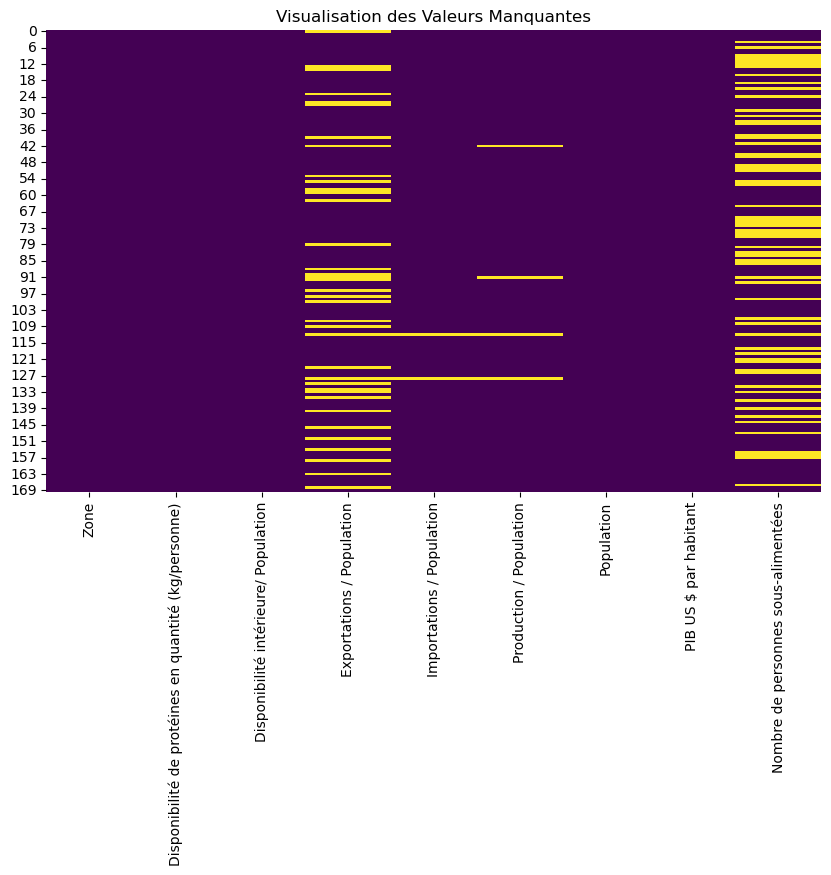

In [106]:
fc.visualiser_valeurs_manquantes(data)

Au vu des valeurs manquantes par colonne, on peut décider de supprimer la colonne avec la sous-nutrition car il manque trop de données pour pouvoir l'utiliser.

Pour les exportations, on peut partir du principe que les valeurs manquantes peuvent être remplacées par 0 car cela signifie que le pays n'a pas d'exportations du produit.

Pour les autres données, nous allons imputer la médiane à la place des NaN.

Pour la colonne Population nous allons la retirer également car elle est déjà présente dans l'étude via la pondération de chaque colonne

In [107]:
# drop la colonne
data.drop(columns=['Nombre de personnes sous-alimentées'], inplace=True)
data.drop(columns=['Population'], inplace = True)

In [108]:
# rempalce par 0
data['Exportations / Population'].fillna(0, inplace=True)
data['Importations / Population'].fillna(0, inplace=True)

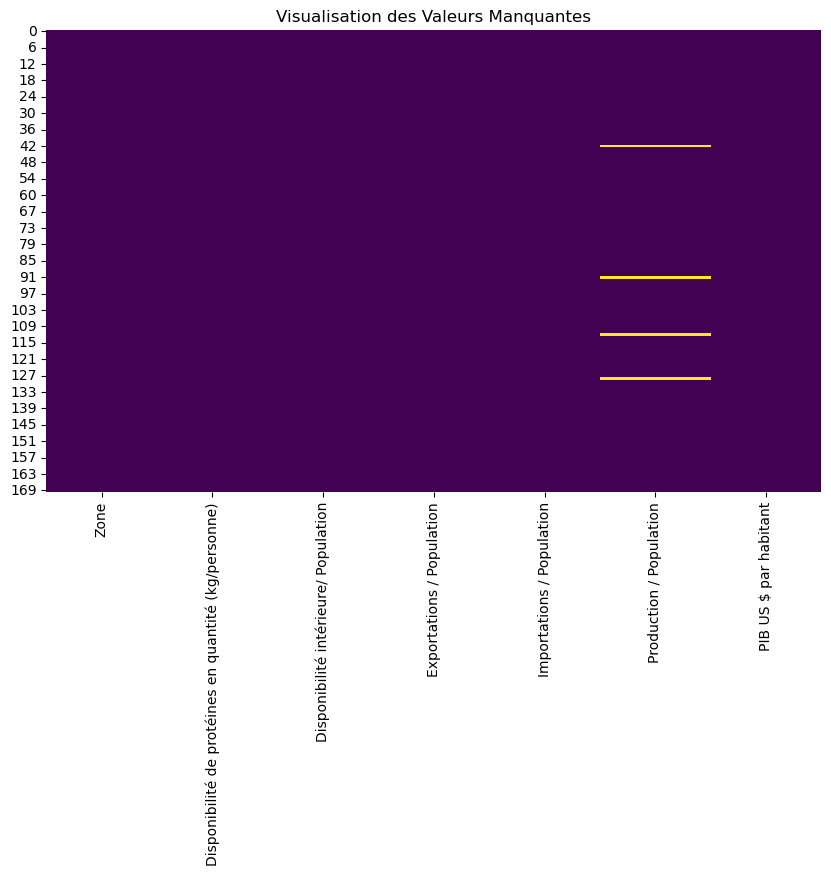

In [109]:
fc.visualiser_valeurs_manquantes(data)

In [110]:
data.dropna(inplace=True)

In [111]:
names = data.Zone.values
names

array(['Afghanistan', 'Afrique du Sud', 'Albanie', 'Algérie', 'Allemagne',
       'Angola', 'Antigua-et-Barbuda', 'Arabie saoudite', 'Argentine',
       'Arménie', 'Australie', 'Autriche', 'Azerbaïdjan', 'Bahamas',
       'Bangladesh', 'Barbade', 'Belgique', 'Belize',
       'Bolivie (État plurinational de)', 'Bosnie-Herzégovine',
       'Botswana', 'Brésil', 'Bulgarie', 'Burkina Faso', 'Bélarus',
       'Bénin', 'Cabo Verde', 'Cambodge', 'Cameroun', 'Canada', 'Chili',
       'Chine - RAS de Hong-Kong', 'Chine - RAS de Macao',
       'Chine, continentale', 'Chypre', 'Colombie', 'Congo', 'Costa Rica',
       'Croatie', 'Cuba', "Côte d'Ivoire", 'Danemark', 'Dominique',
       'El Salvador', 'Espagne', 'Estonie', 'Eswatini', 'Fidji',
       'Finlande', 'France', 'Fédération de Russie', 'Gabon', 'Gambie',
       'Ghana', 'Grenade', 'Grèce', 'Guatemala', 'Guinée',
       'Guinée-Bissau', 'Guyana', 'Géorgie', 'Haïti', 'Honduras',
       'Hongrie', 'Indonésie', "Iran (République islamique d')

## Etude outliers

In [112]:
fc.etude_outliers(data,  seuil=2.0)

Le pourcentage de valeurs considérées comme des outliers en utilisant le Z-score au seuil 2.0 dans la colonne 'Disponibilité de protéines en quantité (kg/personne)' est 4.24%
Le pourcentage de valeurs considérées comme des outliers en utilisant le Z-score au seuil 2.0 dans la colonne 'Disponibilité intérieure/ Population' est 4.24%
Le pourcentage de valeurs considérées comme des outliers en utilisant le Z-score au seuil 2.0 dans la colonne 'Exportations / Population' est 3.03%
Le pourcentage de valeurs considérées comme des outliers en utilisant le Z-score au seuil 2.0 dans la colonne 'Importations / Population' est 6.06%
Le pourcentage de valeurs considérées comme des outliers en utilisant le Z-score au seuil 2.0 dans la colonne 'Production / Population' est 5.45%
Le pourcentage de valeurs considérées comme des outliers en utilisant le Z-score au seuil 2.0 dans la colonne 'PIB US $ par habitant' est 6.06%


On va utiliser la fonction log afin de limiter l'impact des outliers lors de l'analyse

In [113]:
# Selection des colonnes
colonnes = ['Disponibilité de protéines en quantité (kg/personne)','Disponibilité intérieure/ Population',\
    'Exportations / Population', 'Importations / Population', \
    'PIB US $ par habitant']
# Application fonction log
data[colonnes] = np.log(data[colonnes])

c:\Users\antoi\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [114]:
data.describe()

c:\Users\antoi\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant
count,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000
mean,7.422096,5.352577,-inf,-inf,16.062314,8.685729
std,1.159875,2.523227,NaN,NaN,16.999800,1.398866
min,2.681022,-1.986175,-inf,-inf,0.000000,6.027653
25%,6.715262,3.707857,NaN,-0.864014,2.270299,7.571409
50%,7.794514,5.283123,NaN,1.371652,9.604191,8.716304
75%,8.245542,6.716472,0.525939,2.457401,24.216504,9.774779
max,9.227448,11.812360,4.508079,4.821447,76.307170,11.610079


In [115]:
data.replace(-np.inf, 0, inplace=True)

In [116]:
data_num = data.select_dtypes(include='number')

## Normalisation

In [117]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
data = scaler.fit_transform(data_num)
# Convert the scaled data back into a DataFrame
data = pd.DataFrame(data, columns=data_num.columns)

# Display the first few rows of the scaled data
data.head()

,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant
0,-1.640748,-1.193612,0.000000,-0.649493,-0.402473,-1.108822
1,0.491588,-0.259106,0.189995,0.336682,0.894770,0.044080
2,-0.039494,0.462597,0.000000,0.491070,-0.232230,-0.135996
3,-0.795007,-0.807085,0.000000,-1.791128,-0.134871,-0.176583
4,0.117503,-0.572858,3.909364,0.386350,0.396982,0.903506


## StandardScaler

In [118]:
# # Create a StandardScaler
# scaler = StandardScaler()

# # Standardize the columns
# data[colonnes] = scaler.fit_transform(data[colonnes])

# # Display the first few rows of the DataFrame
# data.head()

Création d'un dexième DF avec seulement les données numrériques

In [119]:
data_num = data.select_dtypes(include='number')

On va maintenant regarder la distribution de chacune de nos variables

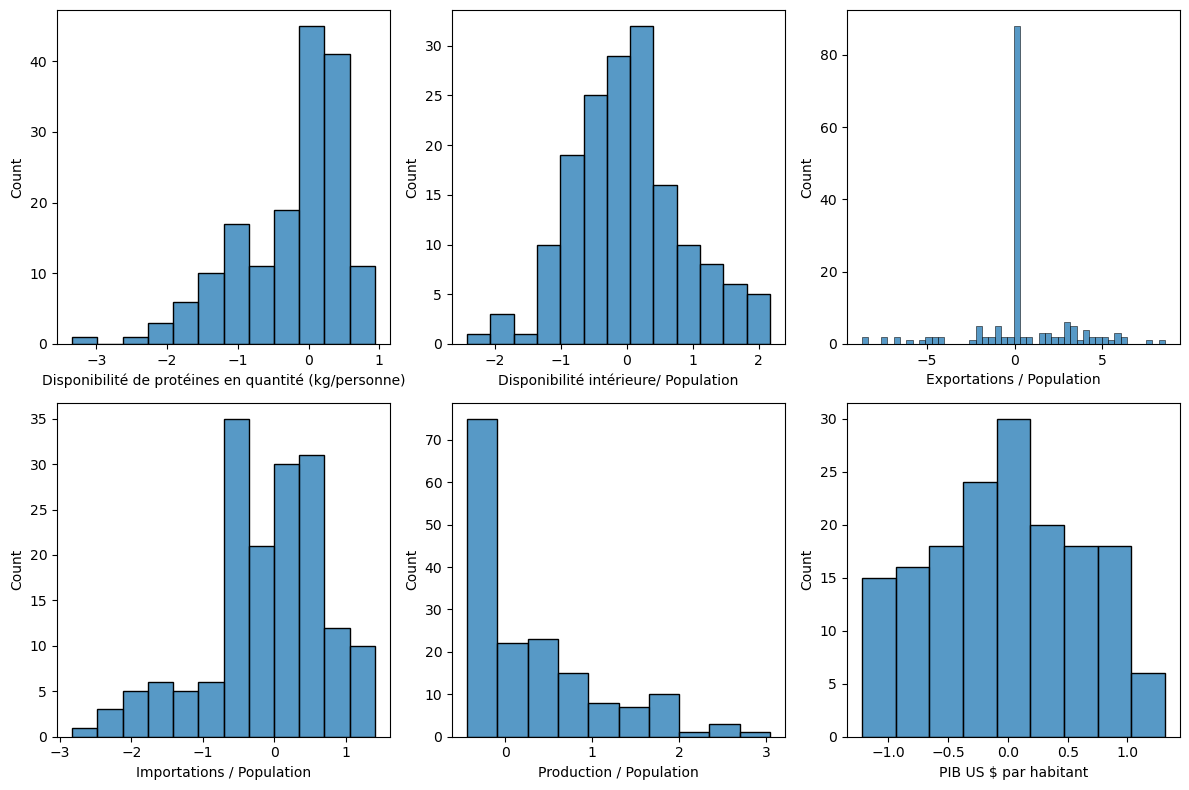

In [120]:
# tracer les distributions des dimensions
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

sns.histplot(data_num['Disponibilité de protéines en quantité (kg/personne)'], ax=axes[0, 0])
sns.histplot(data_num['Disponibilité intérieure/ Population'], ax=axes[0, 1])
sns.histplot(data_num['Exportations / Population'], ax=axes[0, 2])
sns.histplot(data_num['Importations / Population'], ax=axes[1, 0])
sns.histplot(data_num['Production / Population'], ax=axes[1, 1])
sns.histplot(data_num['PIB US $ par habitant'], ax=axes[1, 2])
plt.tight_layout()
plt.show()

On va maintenant regarder la relation entre toutes nos variables

c:\Users\antoi\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


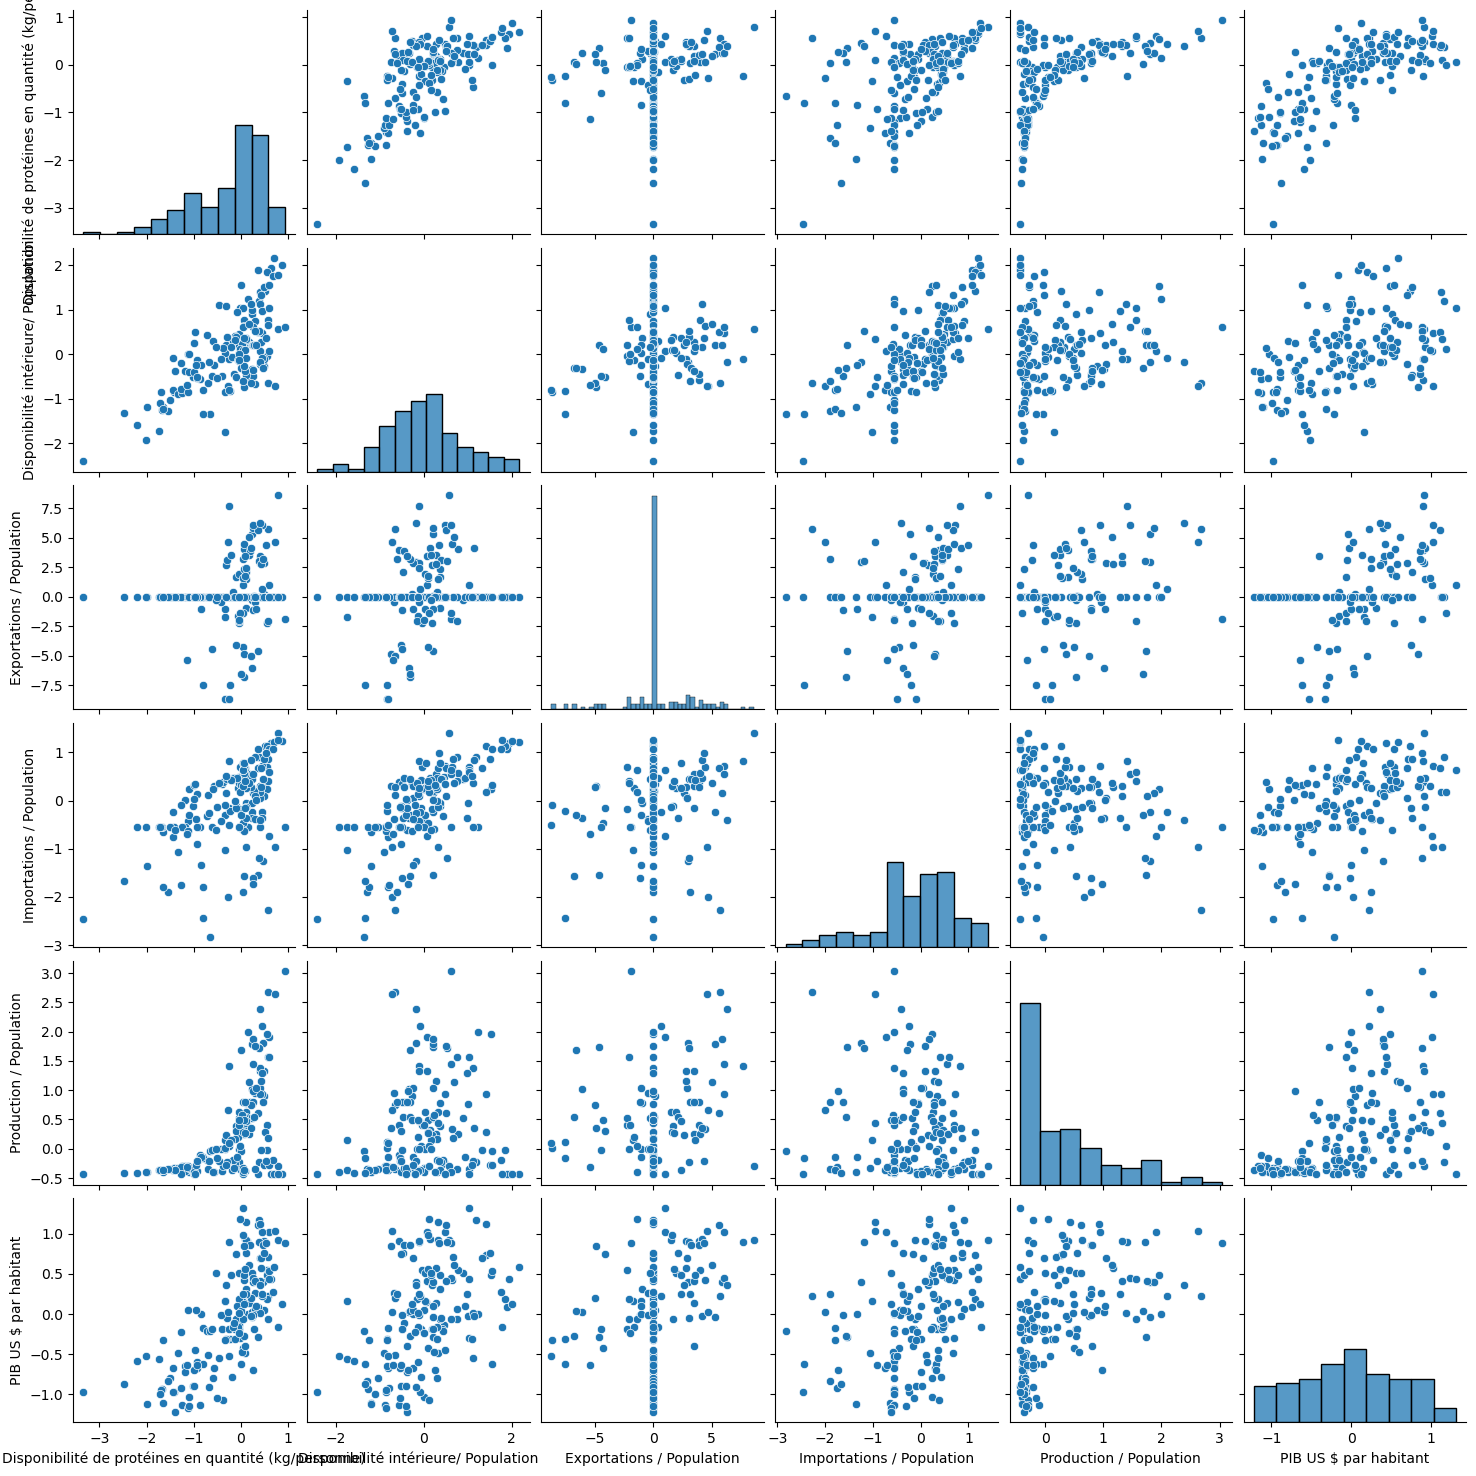

In [121]:
sns.pairplot(data)

## Correlations

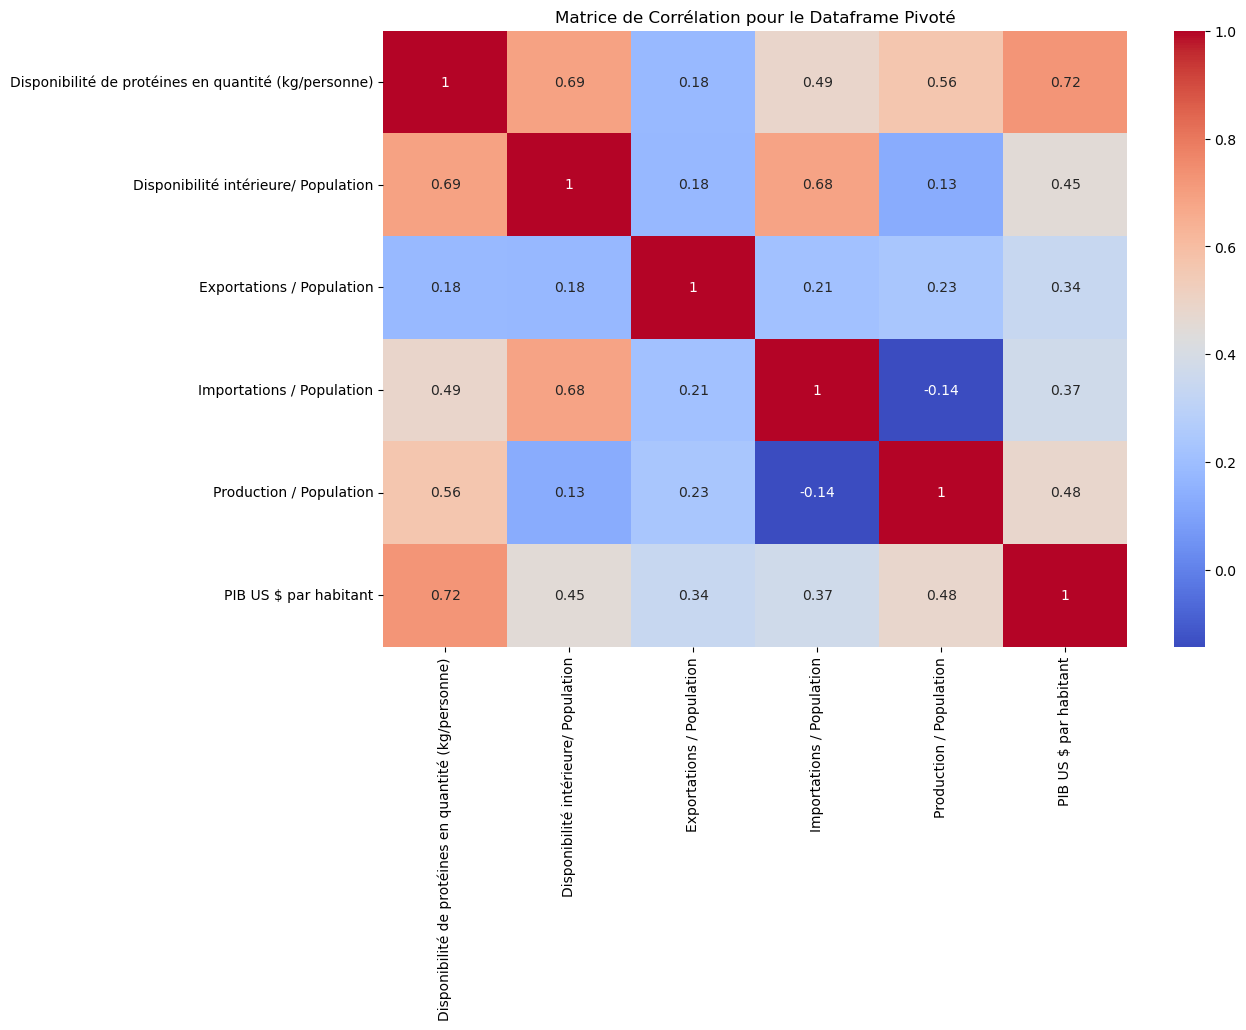

In [122]:
# Calcul de la matrice de corrélation pour le dataframe pivoté
correlation = data_num.corr()

# Visualisation de la matrice de corrélation
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Matrice de Corrélation pour le Dataframe Pivoté')
plt.show()

In [123]:
data.to_csv('data.csv', index=False)